In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric

from cvnets.yolo.voc import load_voc_dataset

plt.rcParams["text.usetex"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["font.family"] = "monospace"

plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
dataset, classes = load_voc_dataset("~/Documents/Datasets/VOC/", split="train")

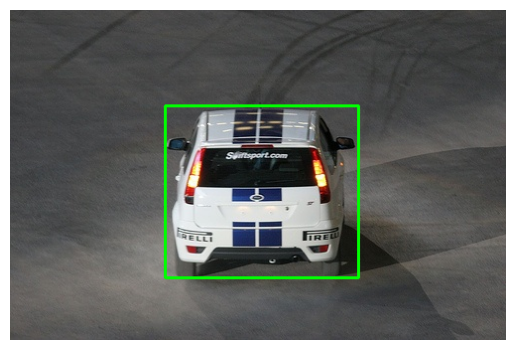

In [3]:
sample = dataset[0]

image = cv.imread(sample.path, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
bboxes = list(d.bbox for d in sample.detections)

for bbox in bboxes:
    cv.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
def xyxy2xywh(bboxes: NDArray) -> NDArray:
    xywh = np.zeros_like(bboxes)
    xywh[:, :2] = bboxes[:, :2] + 0.5 * (bboxes[:, 2:] - bboxes[:, :2])
    xywh[:, 2:] = bboxes[:, 2:] - bboxes[:, :2]
    return xywh


bboxes = list()
imgwhs = list()

for sample in dataset:
    for detection in sample.detections:
        bboxes.append(detection.bbox)
        imgwhs.append((sample.width, sample.height))

bboxes = np.asarray(bboxes, dtype=np.float32)
imgwhs = np.asarray(imgwhs, dtype=np.float32)

bboxes_wh_norm = xyxy2xywh(bboxes)[:, 2:] / imgwhs

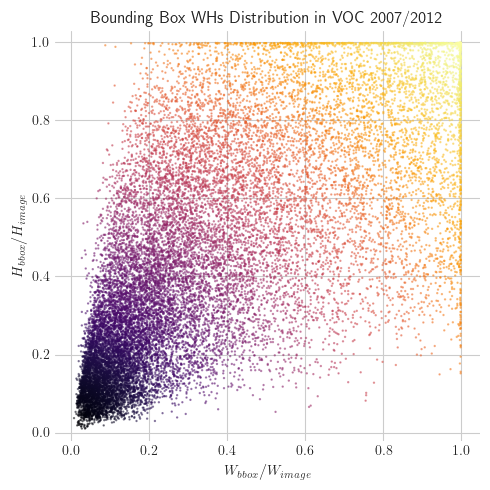

In [5]:
plt.figure(figsize=(5, 5), tight_layout=True)
plt.scatter(
    bboxes_wh_norm[:, 0],
    bboxes_wh_norm[:, 1],
    s=0.5,
    alpha=0.5,
    cmap="inferno",
    c=np.hypot(bboxes_wh_norm[:, 0], bboxes_wh_norm[:, 1]),
)
plt.axis("equal")
plt.xlabel(r"$W_{bbox}\big/W_{image}$")
plt.ylabel(r"$H_{bbox}\big/H_{image}$")
plt.title("Bounding Box WHs Distribution in VOC 2007/2012")
plt.show()

In [6]:
def anchor_iou(whs1: NDArray, whs2: NDArray) -> NDArray:
    area1 = whs1[..., 0] * whs1[..., 1]
    area2 = whs2[..., 0] * whs2[..., 1]
    intersection = np.minimum(whs1[..., 0], whs2[..., 0]) * np.minimum(whs1[..., 1], whs2[..., 1])
    return intersection / (area1 + area2 - intersection + 1e-6)


def anchor_iou_distance(bbox: NDArray, cluster: NDArray) -> NDArray:
    iou_dist = 1 - anchor_iou(bbox.reshape(1, -1), cluster.reshape(1, -1))
    return iou_dist.item()

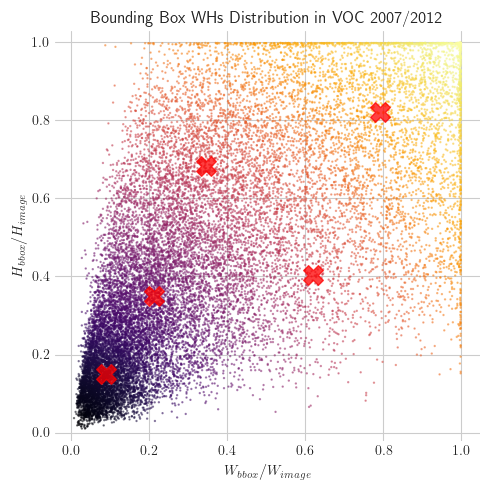

In [7]:
n_clusters = 5
initial_clusters = np.random.rand(n_clusters, 2)
metric = distance_metric(type_metric.USER_DEFINED, func=anchor_iou_distance)

km = kmeans(data=bboxes_wh_norm, initial_centers=initial_clusters, metric=metric)
km = km.process()

anchor_bboxes = np.asarray(km.get_centers())

plt.figure(figsize=(5, 5), tight_layout=True)
plt.scatter(
    bboxes_wh_norm[:, 0],
    bboxes_wh_norm[:, 1],
    s=0.5,
    alpha=0.5,
    cmap="inferno",
    c=np.hypot(bboxes_wh_norm[:, 0], bboxes_wh_norm[:, 1]),
)
plt.scatter(anchor_bboxes[:, 0], anchor_bboxes[:, 1], s=200, alpha=0.75, c="r", marker="X")
plt.axis("equal")
plt.xlabel(r"$W_{bbox}\big/W_{image}$")
plt.ylabel(r"$H_{bbox}\big/H_{image}$")
plt.title("Bounding Box WHs Distribution in VOC 2007/2012")
plt.show()

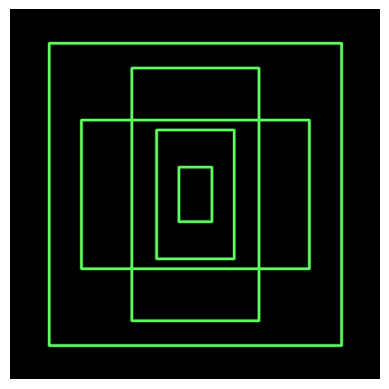

In [8]:
def draw_anchor_bboxes(
    anchor_bboxes: NDArray, imgsz: int = 448, save: bool = False, filename: str | None = None
) -> NDArray:
    blank = np.full((imgsz, imgsz, 3), 0, dtype=np.uint8)
    for w, h in np.multiply(anchor_bboxes, imgsz):
        pt1 = (int(imgsz / 2) - int(w / 2), int(imgsz / 2) - int(h / 2))
        pt2 = (int(imgsz / 2) + int(w / 2), int(imgsz / 2) + int(h / 2))
        cv.rectangle(blank, pt1, pt2, (95, 255, 95), 2, cv.LINE_AA)
    if save:
        filename = filename if filename is not None else "anchors.png"
        cv.imwrite(filename, cv.cvtColor(blank, cv.COLOR_RGB2BGR))
    return blank


blank = draw_anchor_bboxes(anchor_bboxes)

plt.imshow(blank)
plt.axis("off")
plt.show()

In [9]:
def calculate_mean_iou_per_cluster(whs_norm: NDArray, anchor_bboxes: NDArray, clusters_ids: list[list[str]]) -> None:
    ious = list()

    for cluster_ids, anchor_bbox in zip(clusters_ids, anchor_bboxes):
        n_elements = len(cluster_ids)
        cluster_ious = anchor_iou(whs_norm[cluster_ids], anchor_bbox)
        mean_cluster_iou = cluster_ious.mean()
        ious.append(cluster_ious)
        print(f"Anchor BBox: {anchor_bbox} Elements: {n_elements} Mean IOU: {mean_cluster_iou:.4f}")

    ious = np.hstack(ious)
    print(f"Overall Mean IOU: {ious.mean():.4f}")


calculate_mean_iou_per_cluster(bboxes_wh_norm, anchor_bboxes, km.get_clusters())  # type: ignore

Anchor BBox: [0.79093152 0.82122171] Elements: 3765 Mean IOU: 0.7382
Anchor BBox: [0.21288472 0.35066617] Elements: 5063 Mean IOU: 0.5973
Anchor BBox: [0.61998326 0.40429211] Elements: 2246 Mean IOU: 0.6574
Anchor BBox: [0.34539905 0.6834628 ] Elements: 3393 Mean IOU: 0.6939
Anchor BBox: [0.0909491  0.15134302] Elements: 5443 Mean IOU: 0.4826
Overall Mean IOU: 0.6159
